# Energy Analysis
We will be using the new energy layer to analyze the following future PV options
- SHJ
- Perovskite (tandem?)
- 50-year PERC module (multiple uses)
- Recycled Si PERC (Fraunhofer)
- Cheap crap module
- CdTe?

We will use a literture-sourced global scale deployment schedule through 2050, then assume that capacity increases at a lower constant rate through 2100.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10, 6)

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'EnergyAnalysis')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [2]:
#creating scenarios for identical power of multiple technologies
scennames = ['PERC_50','SHJ','Perovskite','RecycledPERC','CheapCrap','Repowered'] #might need a PV ICE baseline too
MATERIALS = ['glass','silver','silicon', 'copper', 'aluminium_frames'] #'encapsulant', 'backsheet',
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

We will be deploying based on power (not area) because each of these have different efficiencies, and those differences should be accounted for in the simulation. Additionally, we will run the installation compensation to simulate the required replacements for each module type.

In [3]:
#load in a baseline and materials for modification
import PV_ICE

sim1 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scen in scennames:
    sim1.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim1.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\EnergyAnalysis


In [ ]:
#idx_late = pd.RangeIndex(start=2050,stop=2101,step=1) #create the index
#proj_2050_2100_energyIncrease = pd.DataFrame(index=idx_late, columns=['World_cum'], dtype=float) #turn into df 

## Module Types Creation

In [7]:
sim1.scenario.keys()

dict_keys(['PERC_50', 'SHJ', 'Perovskite', 'RecycledPERC', 'CheapCrap', 'Repowered'])

In [8]:
celltech_modeff = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-modeffimprovements.csv')) #pull in module eff
celltech_aguse = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-Agusageimprovements.csv')) #pull in Ag use

In [46]:
#glass-glass package mass per area calculation
#ITRPV 2022 Figs 36 and 38, we are assuming that the front and back glass heave equal thickness of 2.5mm
density_glass = 2500*1000 # g/m^3 
glassperm2 = (2.5/1000)* 2 * density_glass
print('The mass per module area of glass is '+str(glassperm2)+' g/m^2 for all modules with a glass-glass package')

The mass per module area of glass is 12500.0 g/m^2 for all modules with a glass-glass package


#### PERC_50

In [35]:
#silver modify for PERC
sim1.scenario['PERC_50'].material['silver'].matdataIn_m.loc[20:(20+len(celltech_aguse)-1),'mat_massperm2'] = celltech_aguse['PERC'].values

In [ ]:
#modify package to glass glass
sim1.scenario['PERC_50'].material['glass'].matdataIn_m.loc[20:(20+len(celltech_aguse)-1),'mat_massperm2'] = glassperm2

In [40]:
#module efficiency modify for PERC
sim1.scenario['PERC_50'].dataIn_m.loc[20:(20+len(celltech_modeff)-1),'mod_eff'] = celltech_modeff['PERC'].values

In [45]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('PERC_50', 'mod_degradation', 0.445, start_year=2022) #annual power degradation to reach 80% at 50 yrs
#T50
sim1.modifyScenario('PERC_50', 'mod_reliability_t50', 56.07, start_year=2022)
#t90
sim1.modifyScenario('PERC_50', 'mod_reliability_t90', 59.15, start_year=2022) 
#Mod Project Lifetime
sim1.modifyScenario('PERC_50', 'mod_lifetime', 50, start_year=2022) #project lifetime of 50 years
#Merchant Tail set high
sim1.modifyScenario('PERC_50', 'mod_MerchantTail', 100, start_year=2022) #all installations stay for merchant tail

In [ ]:
#Change to no recycling

In [ ]:
#include bifaciality of 0.7%

In [44]:
sim1.scenario['PERC_50'].dataIn_m.keys()

Index(['year', 'new_Installed_Capacity_[MW]', 'mod_eff', 'mod_reliability_t50',
       'mod_reliability_t90', 'mod_degradation', 'mod_lifetime', 'mod_MFG_eff',
       'mod_Repair', 'mod_MerchantTail', 'mod_EOL_collection_eff',
       'mod_EOL_pg0_resell', 'mod_EOL_pg1_landfill', 'mod_EOL_pg2_stored',
       'mod_EOL_pg3_reMFG', 'mod_EOL_pg4_recycled', 'mod_EOL_reMFG_yield',
       'mod_EOL_sp_reMFG_recycle', 'mod_EOL_pb1_landfill',
       'mod_EOL_pb2_stored', 'mod_EOL_pb3_reMFG', 'mod_EOL_pb4_recycled'],
      dtype='object')

#### SHJ

In [37]:
#silver modify for SHJ
sim1.scenario['SHJ'].material['silver'].matdataIn_m.loc[20:(20+len(celltech_aguse)-1),'mat_massperm2'] = celltech_aguse['SHJ'].values

In [41]:
#module efficiency modify for PERC
sim1.scenario['SHJ'].dataIn_m.loc[20:(20+len(celltech_modeff)-1),'mod_eff'] = celltech_modeff['SHJ'].values

#### Perovskite

#### Recycled PERC

#### Cheap Crap

#### Repowered

### Modify Years 2000 to 2100
We do this after we modify the baselines to propogate the modified 2050 values forward

In [4]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim1.trim_Years(startYear=2000, endYear=2100)

Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100


In [5]:
sim1.scenario['SHJ'].material['glass'].matdataIn_e

,year,e_mat_extraction,e_mat_MFG,e_mat_MFG_fuelfraction,e_mat_MFGScrap_LQ,e_mat_MFGScrap_HQ,e_mat_Landfill,e_mat_Landfill_fuelfraction,e_mat_EoL_ReMFG_clean,e_mat_Recycled_LQ,...,e_mod_MFG,e_mod_Install,e_mod_OandM,e_mod_Repair,e_mod_Demount,e_mod_Demount_fuelfraction,e_mod_Resell_Certify,e_mod_Store,e_mod_ReMFG_Disassembly,e_mod_Recycle_Crush
0,2000,0.0062,4.434640,80.005988,1.4,1.4,0.09,78.0,0.61,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,0.0062,4.382279,79.998397,1.4,1.4,0.09,78.0,0.61,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002,0.0062,4.318724,80.200079,1.4,1.4,0.09,78.0,0.61,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,0.0062,4.255168,80.409933,1.4,1.4,0.09,78.0,0.61,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004,0.0062,4.191613,80.628330,1.4,1.4,0.09,78.0,0.61,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2096,0.0062,3.512724,86.798744,1.4,1.4,0.09,78.0,0.61,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,2097,0.0062,3.512724,86.798744,1.4,1.4,0.09,78.0,0.61,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,2098,0.0062,3.512724,86.798744,1.4,1.4,0.09,78.0,0.61,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,2099,0.0062,3.512724,86.798744,1.4,1.4,0.09,78.0,0.61,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Apply deployment curve
For the full derivation of the deployment curve, see the "PV Installations - Global" development journal. Essentially, the projection is 2000-2021 IRENA historical installation data, 2022 through 2050 is a quadratic fit to achieve 50 TW in 2050, and from 2050 to 2100 is a linear increase to approx 60 TW based on 2000-2021 global increase in electricity capacity (219.32 GW/year).

This is the deployment curve applied to all PV technologies - however, it will be modified for each PV tech using the installation compensation method, increasing it for any replacement modules required to maintain capacity.

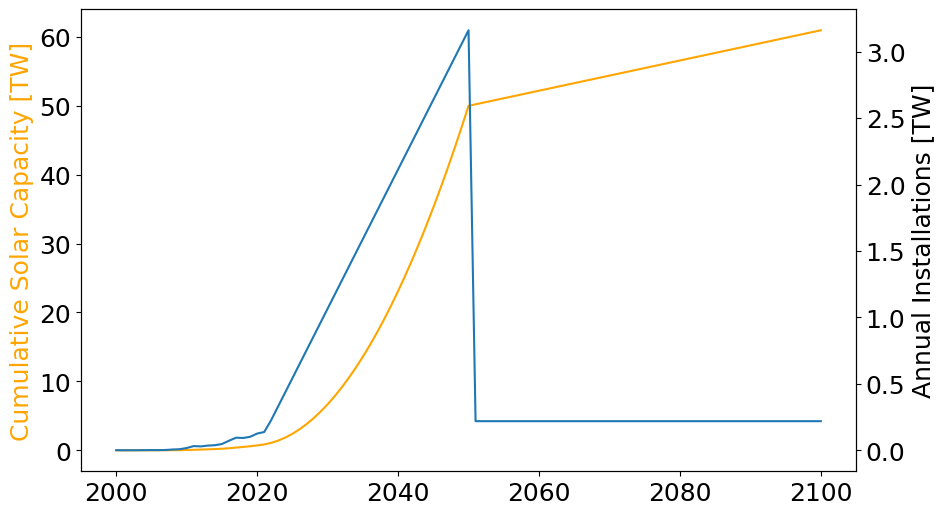

In [42]:
global_projection = pd.read_csv(os.path.join(supportMatfolder,'output-globalInstallsProjection.csv'), index_col=0)

fig, ax1 = plt.subplots()

ax1.plot(global_projection['World_cum']/1e6, color='orange')
ax1.set_ylabel('Cumulative Solar Capacity [TW]', color='orange')
ax2 = ax1.twinx()
ax2.plot(global_projection['World_annual_[MWdc]']/1e6)
ax2.set_ylabel('Annual Installations [TW]')
plt.show()


In [ ]:
#deployment projection
for scen in scennames:
    sim1.scenario[scen].dataIn_m.loc[0:len(global_projection.index-1),'new_Installed_Capacity_[MW]'] = global_projection['World_annual_[MWdc]'].values